# **Example GeoPolRisk | Use case 2**

**Authors:**  
[Romain Sacchi](mailto:romain.sacchi@psi.ch), [Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)


This notebook presents an example to build an edges-based LCA using the GeoPolRisk method.

## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import edges and set bw2 project

In [1]:
from edges import EdgeLCIA, get_available_methods
import bw2data, bw2io

16:29:14+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [2]:
bw2data.projects.set_current("ecoinvent-3.10.1-cutoff")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

In [3]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10.1-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()


classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()

Extracted 1 worksheets in 0.18 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.34 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 226.42it/s]


16:29:26+0200 [info     ] Vacuuming database            
Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU

In [4]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

In [5]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GeoPolRisk', 'elementary flows', '2024'),
 ('GeoPolRisk', 'paired', '2024'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'damage'),
 ('Im

In [6]:
method = ('GeoPolRisk', 'paired', '2024')
method_alt = ('GeoPolRisk', 'elementary flows', '2024')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [7]:
%%time
LCA = EdgeLCIA({act: 1}, method)
LCA.lci()

LCA.map_exchanges()
LCA.map_aggregate_locations()
LCA.map_dynamic_locations()
LCA.map_contained_locations()
LCA.map_remaining_locations_to_global()

No parameters or scenarios found in method file: C:\Users\hahnme_a\PycharmProjects\edges\edges\data\GeoPolRisk_paired_2024.json
Mapping exchanges: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40362/40362 [03:48<00:00, 176.62it/s]


Processed edges: 222
Handling static regions...


Processing static groups (pass 1): 0it [00:00, ?it/s]
Processing static groups (pass 2): 0it [00:00, ?it/s]
Processing static groups (pass 2):   0%|                                                                                                                                                | 0/284 [00:00<?, ?it/s]Fallback CF could not be computed for supplier=(('location', 'VE'), ('name', 'petroleum and gas production, offshore'), ('reference product', 'petroleum')), consumer=(('location', 'RNA'),) with candidate suppliers=('VE',) and consumers=('PM', 'BM', 'GL')
Fallback CF could not be computed for supplier=(('location', 'VE'), ('name', 'petroleum and gas production, onshore'), ('reference product', 'petroleum')), consumer=(('location', 'RNA'),) with candidate suppliers=('VE',) and consumers=('PM', 'BM', 'GL')
Processing static groups (pass 2):   4%|█████▋                                                                                                                                |

Processed edges: 387
Handling dynamic regions...


US-PR not found in regex
IN-DD not found in regex
Processing dynamic groups (pass 1): 0it [00:00, ?it/s]
Processing dynamic groups (pass 2): 0it [00:00, ?it/s]
Processing dynamic groups (pass 1): 0it [00:00, ?it/s]
Processing dynamic groups (pass 2):  21%|████████████████████████████                                                                                                          | 70/335 [00:03<00:13, 20.23it/s]Fallback CF could not be computed for supplier=(('location', 'RoW'), ('name', 'uranium fuel element production, enriched 4.2%, for light water reactor'), ('reference product', 'uranium, enriched 4.2%, in fuel element for light water reactor')), consumer=(('location', 'GLO'),) with candidate suppliers=('AW', 'CW', 'GI', 'SX', 'MO', 'PS', 'ST', 'TK', 'KM', 'KY', 'LU', 'BN', 'CY', 'SZ', 'RW', 'SG', 'SL', 'TG', 'DJ', 'GM', 'IL', 'LB', 'VG', 'AD', 'BY', 'GQ', 'TJ', 'TM', 'AG', 'ER', 'KG', 'NE', 'QA', 'SK', 'BO', 'KE', 'KW', 'ML', 'PK', 'SM', 'VC', 'AT', 'BH', 'DM', 'GA', 'GH'

Processed edges: 685
Handling contained locations...


Processing contained groups (pass 1): 0it [00:00, ?it/s]
Processing contained groups (pass 2): 0it [00:00, ?it/s]
Processing contained groups (pass 2):   0%|                                                                                                                                             | 0/514 [00:00<?, ?it/s]Fallback CF could not be computed for supplier=(('location', 'CN'), ('name', 'uranium hexafluoride production'), ('reference product', 'uranium hexafluoride')), consumer=(('location', 'CN'),) with candidate suppliers=('GLO',) and consumers=('GLO',)
Fallback CF could not be computed for supplier=(('location', 'CN-SC'), ('name', 'rare earth element mine operation and beneficiation, bastnaesite ore'), ('reference product', 'rare earth oxide concentrate, 70% REO')), consumer=(('location', 'CN-SC'),) with candidate suppliers=('CN',) and consumers=('CN',)
Fallback CF could not be computed for supplier=(('location', 'US'), ('name', 'uranium hexafluoride production'), ('referen

Processed edges: 1144
Handling remaining exchanges...


Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 0it [00:00, ?it/s]
Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.18it/s]


Processed edges: 1266
CPU times: total: 3min 18s
Wall time: 4min 50s


In [8]:
LCA.evaluate_cfs()
LCA.lcia()
current_score = LCA.score
print(current_score)
df_table = LCA.generate_cf_table(include_unmatched=True)

No parameter set found for scenario 'None'. Using empty defaults.


0.38563785420634406


#### Run alternative method

In [9]:
LCA_alt = EdgeLCIA({act: 1}, method_alt)
LCA_alt.lci()
LCA_alt.map_exchanges()
LCA_alt.map_aggregate_locations()
LCA_alt.map_dynamic_locations()
LCA_alt.map_contained_locations()
LCA_alt.map_remaining_locations_to_global()
LCA_alt.evaluate_cfs()
LCA_alt.lcia()
alternative_score = LCA_alt.score
print(alternative_score)

No parameters or scenarios found in method file: C:\Users\hahnme_a\PycharmProjects\edges\edges\data\GeoPolRisk_elementary flows_2024.json
Mapping exchanges: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 146.17it/s]


Processed edges: 2829
Handling static regions...


US-PR not found in regex
IN-DD not found in regex
Processing static groups (pass 1): 0it [00:00, ?it/s]
Processing static groups (pass 2): 0it [00:00, ?it/s]
Processing static groups (pass 1): 0it [00:00, ?it/s]
Processing static groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 2829
Handling dynamic regions...


Processing dynamic groups (pass 1): 0it [00:00, ?it/s]
Processing dynamic groups (pass 2): 0it [00:00, ?it/s]
Processing dynamic groups (pass 1): 0it [00:00, ?it/s]
Processing dynamic groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 2829
Handling contained locations...


US-PR not found in regex
IN-DD not found in regex
Processing contained groups (pass 1): 0it [00:00, ?it/s]
Processing contained groups (pass 2): 0it [00:00, ?it/s]
Processing contained groups (pass 1): 0it [00:00, ?it/s]
Processing contained groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 2829
Handling remaining exchanges...


Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 0it [00:00, ?it/s]
Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 2829


No parameter set found for scenario 'None'. Using empty defaults.


0.1350014089718537


<a id="sec_export_results"></a>
# 5. Export results

In [10]:
len(df_table)

160795

In [11]:
len(df_table)

160795

In [12]:
df_table

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,sodium arsenide production from Imperial smelt...,sodium arsenide,GLO,market for sodium arsenide,sodium arsenide,GLO,2.582327e-12,60.984817,1.574827e-10
1,"asbestos production, chrysotile type","asbestos, chrysotile type",GLO,"market for asbestos, chrysotile type","asbestos, chrysotile type",GLO,1.464823e-06,0.233699,3.423270e-07
2,bauxite mine operation,bauxite,GLO,market for bauxite,bauxite,GLO,1.130260e-02,9.742032,1.101103e-01
3,bentonite quarry operation,bentonite,DE,market for bentonite,bentonite,GLO,1.683820e-06,0.000304,5.115543e-10
4,"sodium tetrahydridoborate production, Brown-Sc...",sodium tetrahydridoborate,GLO,market for sodium tetrahydridoborate,sodium tetrahydridoborate,GLO,1.151612e-09,0.267894,3.085099e-10
...,...,...,...,...,...,...,...,...,...
160790,"market for electricity, medium voltage","electricity, medium voltage",TG,"water production, decarbonised","water, decarbonised",RoW,6.456973e-09,NaN,NaN
160791,"market group for electricity, medium voltage","electricity, medium voltage",CA,zinc mine operation,"copper concentrate, sulfide ore",GLO,3.528281e-05,NaN,NaN
160792,"market for cement, unspecified","cement, unspecified",US,"uranium fuel element production, enriched 4.2%...","uranium, enriched 4.2%, in fuel element for li...",RoW,1.737599e-11,NaN,NaN
160793,market for irrigation,irrigation,ZA,maize grain production,maize grain,ZA,3.850597e-10,NaN,NaN


In [13]:
df_table

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,sodium arsenide production from Imperial smelt...,sodium arsenide,GLO,market for sodium arsenide,sodium arsenide,GLO,2.582327e-12,60.984817,1.574827e-10
1,"asbestos production, chrysotile type","asbestos, chrysotile type",GLO,"market for asbestos, chrysotile type","asbestos, chrysotile type",GLO,1.464823e-06,0.233699,3.423270e-07
2,bauxite mine operation,bauxite,GLO,market for bauxite,bauxite,GLO,1.130260e-02,9.742032,1.101103e-01
3,bentonite quarry operation,bentonite,DE,market for bentonite,bentonite,GLO,1.683820e-06,0.000304,5.115543e-10
4,"sodium tetrahydridoborate production, Brown-Sc...",sodium tetrahydridoborate,GLO,market for sodium tetrahydridoborate,sodium tetrahydridoborate,GLO,1.151612e-09,0.267894,3.085099e-10
...,...,...,...,...,...,...,...,...,...
160790,"market for electricity, medium voltage","electricity, medium voltage",TG,"water production, decarbonised","water, decarbonised",RoW,6.456973e-09,NaN,NaN
160791,"market group for electricity, medium voltage","electricity, medium voltage",CA,zinc mine operation,"copper concentrate, sulfide ore",GLO,3.528281e-05,NaN,NaN
160792,"market for cement, unspecified","cement, unspecified",US,"uranium fuel element production, enriched 4.2%...","uranium, enriched 4.2%, in fuel element for li...",RoW,1.737599e-11,NaN,NaN
160793,market for irrigation,irrigation,ZA,maize grain production,maize grain,ZA,3.850597e-10,NaN,NaN


In [14]:
df_table.to_excel("df.xlsx")

In [15]:
LCA.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      |      ('GeoPolRisk', 'paired', '2024')      |
|         Unit         |               kg copper-eq.                |
|      Data file       |           GeoPolRisk_paired_2024           |
|    CFs in method     |                   40362                    |
|       CFs used       |                    1205                    |
|   Unique CFs used    |                    417                     |
|  Exc. characterized  |                    1266                    |
| Exc. uncharacterized |                   159529                   |
+----------------------+--------------------------------------------+


In [16]:
LCA.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      |      ('GeoPolRisk', 'paired', '2024')      |
|         Unit         |               kg copper-eq.                |
|      Data file       |           GeoPolRisk_paired_2024           |
|    CFs in method     |                   40362                    |
|       CFs used       |                    1205                    |
|   Unique CFs used    |                    417                     |
|  Exc. characterized  |                    1266                    |
| Exc. uncharacterized |                   159529                   |
+----------------------+--------------------------------------------+


In [17]:
df_table = df_table.loc[df_table["supplier reference product"] != "coke"]

<a id="sec_plot_results"></a>
# 6. Plot results

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

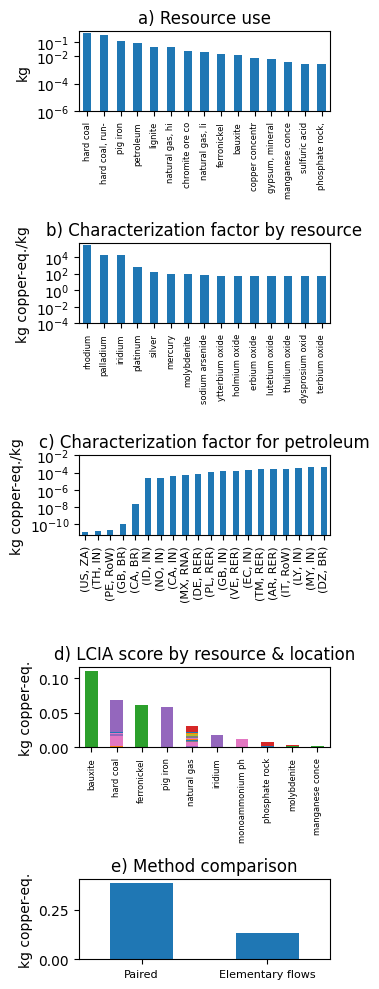

In [19]:
cutoff = 0.00
# remove rows for which "amount" is below the cutoff
m = df_table.loc[df_table["impact"] > 0, "impact"].max()
df = df_table[df_table["impact"] > cutoff * m]
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(3.5, 10))
df_net = df.copy()
d = df_net.groupby(["supplier reference product"])
d = d.sum().sort_values(by="amount", ascending=False)
d["amount"].head(15).plot(kind="bar", ax=axes[0], xlabel='')
axes[0].set_yscale('log')
axes[0].set_title("a) Resource use")
axes[0].set_ylabel("kg")
axes[0].set_xticklabels(
    [x.get_text()[:15] for x in axes[0].get_xticklabels()],
    rotation=90,
)
axes[0].tick_params(axis="x", labelsize=6)
axes[0].set_yticks([1e-6, 1e-4, 1e-2, 1e-1,])
d["CF"] = d["impact"] / d["amount"]
d["CF"].sort_values(ascending=False).head(15).plot(kind="bar", ax=axes[1], xlabel='')
axes[1].set_yscale('log')
axes[1].set_title("b) Characterization factor by resource")
axes[1].set_ylabel("kg copper-eq./kg")
axes[1].set_xticklabels(
    [x.get_text()[:15] for x in axes[1].get_xticklabels()],
    rotation=90,
)
axes[1].tick_params(axis="x", labelsize=6)
axes[1].set_yticks([1e-4, 1e-2, 1e-0, 1e+2, 1e+4])
df_net["CF"] = df_net["impact"] / df_net["amount"]
df_net.replace("Europe without Switzerland", "RER", regex=True, inplace=True)
df_net = df_net.loc[df_net["supplier location"] != df_net["consumer location"]]
df_net = df_net.drop_duplicates(subset=["supplier location", "consumer location"], keep='first')
df_net = df_net.loc[df_net["supplier location"] != "RoW"]
df_net = df_net.loc[df_net["supplier location"] != "RoE"]
df_net = df_net.set_index(["supplier location", "consumer location"])
df_net.loc[df_net["supplier reference product"] == "petroleum", "CF"].sort_values(ascending=True).head(20).plot(kind="bar", ax=axes[2], xlabel='')
axes[2].set_yscale('log')
axes[2].set_title("c) Characterization factor for petroleum")
axes[2].set_ylabel("kg copper-eq./kg")
axes[2].tick_params(axis="x", labelsize=8, rotation=90)
axes[2].set_yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2,])
# 3. Stacked bar plot for "amount" by "consumer name" and "consumer location"
df.loc[:, "supplier reference product"] = df["supplier reference product"].str.split(", ").str[0]
df_grouped = df.groupby(["supplier reference product", "supplier location"])["impact"].sum().unstack()
df_grouped = df_grouped.dropna(how='all', axis=0).dropna(how='all', axis=1)
df_grouped = df_grouped[df_grouped.sum(axis=1) != 0]
df_grouped = df_grouped.loc[:, df_grouped.sum(axis=0) != 0]
df_grouped = df_grouped[df_grouped.sum(axis=1) > 1e-4]
df_grouped = df_grouped.dropna(how='all', axis=0).dropna(how='all', axis=1)
df_grouped = df_grouped.loc[df_grouped.sum(axis=1).sort_values(ascending=False).index]
df_grouped = df_grouped.loc[:, df_grouped.sum() > 1e-4]
row_order = df_grouped.sum(axis=1).sort_values(ascending=False).index
df_grouped = df_grouped.loc[row_order]
df_grouped.head(10).plot(kind="bar", stacked=True, ax=axes[3], xlabel='')
#axes[3].set_yscale('log')
axes[3].set_title("d) LCIA score by resource & location")
axes[3].set_ylabel("kg copper-eq.")
axes[3].set_xticklabels(
    [x.get_text()[:15] for x in axes[3].get_xticklabels()],
    rotation=90,
)
axes[3].tick_params(axis="x", labelsize=6)
#axes[3].legend_.remove()
#axes[3].legend(
#    loc='upper right',
#    #bbox_to_anchor=(0.1, 0),
#    ncol=6,
#    fontsize=7,
#    frameon=False
#)
axes[3].legend().remove()
#axes[3].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0, 2.0, 5.0), numticks=10))
axes[3].set_yticks([0.0, 0.05, 0.10])

# New fifth panel - Method comparison
import pandas as pd
method_comparison = pd.DataFrame({
    'Method': ['Paired', 'Elementary flows'],
    'Score': [current_score, alternative_score]
})
method_comparison.plot(x='Method', y='Score', kind='bar', ax=axes[4], xlabel='', legend=False)
axes[4].set_title("e) Method comparison")
axes[4].set_ylabel("kg copper-eq.")
axes[4].set_xticklabels(['Paired', 'Elementary flows'], rotation=0)
axes[4].tick_params(axis="x", labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space at the top for the legend
#plt.savefig("figure_2.png", bbox_inches="tight", dpi=150)
plt.show()